In [2]:
from pathlib import Path
import re

import eelbrain
import mne
import trftools

In [3]:
STIMULI = [str(i) for i in range(1, 12)]
DATA_ROOT = Path("~").expanduser() / 'Data' / 'LittlePrince'
PREDICTOR_DIR = DATA_ROOT / 'predictors'
EEG_DIR = DATA_ROOT / 'eeg'
#SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'S\d*', path.name)]
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs'
TRF_DIR.mkdir(exist_ok=True)

In [4]:
# Load stimuli
# ------------
# Make sure to name the stimuli so that the TRFs can later be distinguished
# Load the gammatone-spectrograms; use the time axis of these as reference
gammatone = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-8.pickle') for stimulus in STIMULI]

# Resample the spectrograms to 100 Hz (time-step = 0.01 s), which we will use for TRFs
gammatone = [x.bin(0.01, dim='time', label='start') for x in gammatone]

# Pad onset with 100 ms and offset with 1 second; make sure to give the predictor a unique name as that will make it easier to identify the TRF later
gammatone = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='gammatone') for x in gammatone]

# Load the broad-band envelope and process it in the same way
envelope = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-1.pickle') for stimulus in STIMULI]
envelope = [x.bin(0.01, dim='time', label='start') for x in envelope]
envelope = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='envelope') for x in envelope]
onset_envelope = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-on-1.pickle') for stimulus in STIMULI]
onset_envelope = [x.bin(0.01, dim='time', label='start') for x in onset_envelope]
onset_envelope = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='onset') for x in onset_envelope]

# Load onset spectrograms and make sure the time dimension is equal to the gammatone spectrograms
gammatone_onsets = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~gammatone-on-8.pickle') for stimulus in STIMULI]
gammatone_onsets = [x.bin(0.01, dim='time', label='start') for x in gammatone_onsets]
gammatone_onsets = [eelbrain.set_time(x, gt.time, name='gammatone_on') for x, gt in zip(gammatone_onsets, gammatone)]

# Load word tables and convert tables into continuous time-series with matching time dimension
#word_tables = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~word.pickle') for stimulus in STIMULI]
#word_onsets = [eelbrain.event_impulse_predictor(gt.time, ds=ds, name='word') for gt, ds in zip(gammatone, word_tables)]

# Function and content word impulses based on the boolean variables in the word-tables
#word_lexical = [eelbrain.event_impulse_predictor(gt.time, value='lexical', ds=ds, name='lexical') for gt, ds in zip(gammatone, word_tables)]
#word_nlexical = [eelbrain.event_impulse_predictor(gt.time, value='nlexical', ds=ds, name='non_lexical') for gt, ds in zip(gammatone, word_tables)]

# Extract the duration of the stimuli, so we can later match the EEG to the stimuli
durations = [gt.time.tmax for stimulus, gt in zip(STIMULI, gammatone)]


In [5]:
# Models
# ------
# Pre-define models here to have easier access during estimation. In the future, additional models could be added here and the script re-run to generate additional TRFs.
models = {
    # Acoustic models
    'envelope': [envelope],
#    'envelope+onset': [envelope, onset_envelope],
#    'acoustic': [gammatone, gammatone_onsets],
    # Models with word-onsets and word-class
#    'words': [word_onsets],
#    'words+lexical': [word_onsets, word_lexical, word_nlexical],
#    'acoustic+words': [gammatone, gammatone_onsets, word_onsets],
#    'acoustic+words+lexical': [gammatone, gammatone_onsets, word_onsets, word_lexical, word_nlexical],
}

In [41]:
SUBJECTS=['R0443_20170525_LittlePrince', 'R0459_20170616_LittlePrince', 'R0462_20170621_LittlePrince']

subject = SUBJECTS[2]
subject_trf_dir = TRF_DIR / subject
subject_trf_dir.mkdir(exist_ok=True)
    
# Generate all TRF paths so we can check whether any new TRFs need to be estimated
trf_paths = {model: subject_trf_dir / f'{subject} {model}.pickle' for model in models}
        
# Load the EEG data
raw = mne.io.read_raw_brainvision(EEG_DIR / subject / f'{subject}EEG_01.vhdr', preload=True)

#raw = mne.io.read_raw_brainvision(f'C:/Dropbox (University of Michigan)/lpp-eeg/{s}/{s}EEG_01.vhdr', preload=True)
#R0420: No S1, R0443: noisy after 553 sec, R0446: noisy, R0454: no S1

In [42]:
raw.filter(0.5, 20)

<RawBrainVision | R0462_20170621_LittlePrinceEEG_01.eeg, 63 x 3151575 (6303.1 s), ~1.48 GB, data loaded>

In [43]:
raw.add_reference_channels('29')
raw.set_eeg_reference(ref_channels = ['25', '29'])

<RawBrainVision | R0462_20170621_LittlePrinceEEG_01.eeg, 64 x 3151575 (6303.1 s), ~1.50 GB, data loaded>

In [44]:
# Pick EEG channels

raw=raw.pick_types(eeg=True, meg=False, exclude=['VEOG', 'OPTO', 'AUD'])

# Set montage

montage = mne.channels.read_custom_montage('easycapM10-acti61_elec.sfp')
raw.set_montage(montage, on_missing='ignore')

C:\Users\LG\AppData\Local\Temp\ipykernel_6516\1734210704.py:8: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='ignore')


<RawBrainVision | R0462_20170621_LittlePrinceEEG_01.eeg, 61 x 3151575 (6303.1 s), ~1.43 GB, data loaded>

In [57]:
eeg = raw.copy().crop(tmax=650) #462: 650

In [12]:
#eeg.info['ch_names']

In [46]:
eeg.plot()

In [58]:
eeg.info['bads'].append('24') #R0443[9, (26, 27), 59], R0446[14, 27, 28, 47, 53, 59] #R0459 [14, 15, 19, 24, 28, 53], #R0462 [24, 30, 56, 25, 31]
eeg.info['bads'].append('30')
eeg.info['bads'].append('56')
eeg.info['bads'].append('25')
eeg.info['bads'].append('31')
#eeg.info['bads'].append('28')
#eeg.info['bads'].append('53')

eeg.interpolate_bads()

<RawBrainVision | R0462_20170621_LittlePrinceEEG_01.eeg, 61 x 325001 (650.0 s), ~151.3 MB, data loaded>

In [125]:
eeg.plot()

In [59]:
filt_raw = eeg.copy().filter(l_freq=1., h_freq=None)
ica = mne.preprocessing.ICA(n_components=25, max_iter='auto', random_state=97)
ica.fit(filt_raw)
ica

Method,fastica
Fit,29 iterations on raw data (325001 samples)
ICA components,25
Explained variance,100.0 %
Available PCA components,61
Channel types,eeg
ICA components marked for exclusion,—


In [49]:
filt_raw.load_data()
ica.plot_sources(filt_raw, show_scrollbars=True);

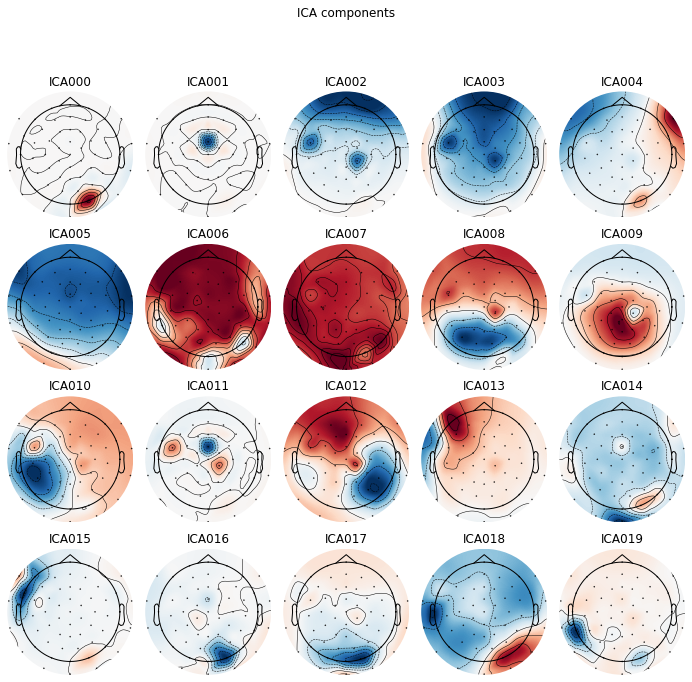

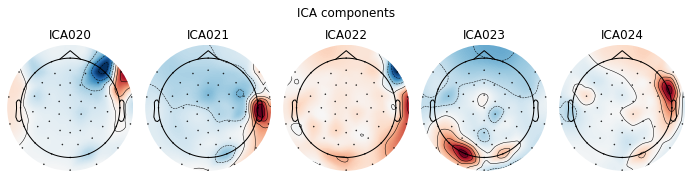

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x187.56 with 5 Axes>]

In [60]:
ica.plot_components()

In [61]:
#ica.exclude = [4, 8] #R0443
#ica.exclude = [3, 4] #R0459
ica.exclude = [0, 1, 2, 4] #R0462

ica.apply(eeg)

<RawBrainVision | R0462_20170621_LittlePrinceEEG_01.eeg, 61 x 325001 (650.0 s), ~151.3 MB, data loaded>

In [53]:
eeg.plot()

In [22]:
eeg.save('C:/Users/LG/Data/LittlePrince/eeg/R0443_ref_preprocessed_raw.fif', overwrite=True)

In [62]:
# Get data from the paragraph onset
event_id={'onset': 1}
events = mne.events_from_annotations(raw)
events = events[0]
dur = sum(durations)

epochs = mne.Epochs(eeg, events, event_id, tmin=-0.1, tmax=566.53, baseline=(None,0.), preload=True)

In [63]:
epochs

Number of events,1
Events,onset: 1
Time range,-0.100 – 566.530 sec
Baseline,-0.100 – 0.000 sec


In [64]:
# Resample and concatenate
epoch_downsampled = epochs.copy().resample(sfreq=100)
resp = eelbrain.load.fiff.epochs_ndvar(epoch_downsampled, -0.100, connectivity='auto')
resp_concatenated = eelbrain.concatenate(resp)

In [65]:
resp_concatenated.get_dim('time')

UTS(0.0, 0.01, 56663)

In [101]:
predictors_concatenated[0].get_dim("time") #sampling rate = 100

UTS(0.0, 0.01, 56663)

In [37]:
    trial_indexes = [int(i)-1 for i in STIMULI]
    trial_durations = durations
    
    for model, predictors in models.items():
        path = trf_paths[model]
        # Skip if this file already exists
        #if path.exists():
        #    continue
        #print(f"Estimating: {subject} ~ {model}")
        
        # Select and concetenate the predictors corresponding to the EEG trials
        predictors_concatenated = []
        for predictor in predictors:
            predictors_concatenated.append(eelbrain.concatenate([predictor[i] for i in trial_indexes]))

In [24]:
eelbrain.configure(n_workers=False)

In [ ]:
        # Fit the mTRF
        trf = eelbrain.boosting(resp_concatenated, predictors_concatenated, -0.100, 1.000, error='l1', basis=0.050, partitions=5, test=1, selective_stopping=True)
        
        # Save the TRF for later analysis
        #eelbrain.save.pickle(trf, path)

Fitting models:   0%|          | 0/1220 [00:00<?, ?it/s]

In [40]:
eelbrain.save.pickle(trf, 'C:/Users/LG/Data/LittlePrince/TRFs/R0462 re_envelope.pickle')

# Figure

boosting result: https://eelbrain.readthedocs.io/en/stable/generated/eelbrain.BoostingResult.html

In [26]:
import re
import os
import trftools
from scipy.io import loadmat
from eelbrain import *
from matplotlib import pyplot

In [145]:
trf = eelbrain.load.unpickle(TRF_DIR / subject / f'{subject} envelope.pickle')

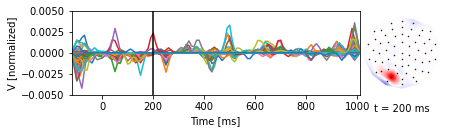

In [39]:
p = plot.TopoButterfly(trf.h, w=6, h=2)
p.set_time(.20)

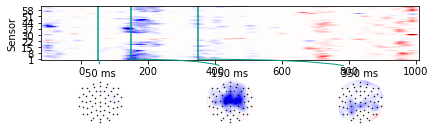

In [34]:
p = plot.TopoArray(trf.h, w=6, h=2, t=(.050, .150, .350))

In [69]:
subject = 'S01'
DATA_ROOT = Path("~").expanduser() / 'Data' / 'Alice'
PREDICTOR_DIR = DATA_ROOT / 'predictors'
EEG_DIR = DATA_ROOT / 'eeg'
TRF_DIR = DATA_ROOT / 'TRFs'

trf1 = eelbrain.load.unpickle(TRF_DIR / subject / f'{subject} envelope.pickle')

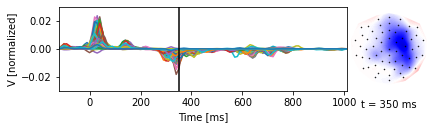

In [71]:
p = plot.TopoButterfly(trf1.h, w=6, h=2)
p.set_time(.35)

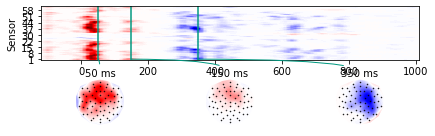

In [70]:
p = plot.TopoArray(trf1.h, w=6, h=2, t=(.050, .150, .350))

In [11]:
# Estimate TRFs
# -------------
# Loop through subjects to estimate TRFs
for subject in SUBJECTS:
    subject_trf_dir = TRF_DIR / subject
    subject_trf_dir.mkdir(exist_ok=True)
    
    # Generate all TRF paths so we can check whether any new TRFs need to be estimated
    trf_paths = {model: subject_trf_dir / f'{subject} {model}.pickle' for model in models}
    
    # Skip this subject if all files already exist
    if all(path.exists() for path in trf_paths.values()):
        continue
    
    # Load the EEG data
    raw = mne.io.read_raw_brainvision(EEG_DIR / subject / f'{subject}_LittlePrinceEEG_01.eeg', preload=True)
    
    # Band-pass filter the raw data between 0.2 and 20 Hz
    raw.filter(0.5, 20)
    
    # Interpolate bad channels (proc.badchannels)
    raw.interpolate_bads()
    
    # Extract the events marking the stimulus presentation from the EEG file
    #events = eelbrain.load.fiff.events(raw)
    events = mne.events_from_annotations(raw)
    
    trial_indexes = [STIMULI.index(stimulus) for stimulus in events['event']]
    
    # Extract the EEG data segments corresponding to the stimuli
    trial_durations = [durations[i] for i in trial_indexes]
    eeg = eelbrain.load.fiff.variable_length_epochs(events, -0.100, trial_durations, decim=5, connectivity='auto')
    
    # Since trials are of unequal length, we will concatenate them for the TRF estimation.
    eeg_concatenated = eelbrain.concatenate(eeg)
    
    for model, predictors in models.items():
        path = trf_paths[model]
        # Skip if this file already exists
        if path.exists():
            continue
        print(f"Estimating: {subject} ~ {model}")
        
        # Select and concetenate the predictors corresponding to the EEG trials
        predictors_concatenated = []
        for predictor in predictors:
            predictors_concatenated.append(eelbrain.concatenate([predictor[i] for i in trial_indexes]))
        
        # Fit the mTRF
        trf = eelbrain.boosting(eeg_concatenated, predictors_concatenated, -0.100, 1.000, error='l1', basis=0.050, partitions=5, test=1, selective_stopping=True)
        
        # Save the TRF for later analysis
        eelbrain.save.pickle(trf, path)

Estimating: S01 ~ envelope


Fitting models:   0%|          | 0/1220 [00:00<?, ?it/s]